# 225種類の鳥の分類

## データの読み込み

In [2]:
import os
import gc
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

np.random.seed(seed=42)

import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps, ImageEnhance

from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix 

In [3]:
DATA_DIR = Path.home() / "data/bird_image_225"
train = pd.read_csv(DATA_DIR / "train.csv")
test = pd.read_csv(DATA_DIR / "test.csv")

train_img_path = DATA_DIR / "train"
test_img_path = DATA_DIR / "test"

In [6]:
train.head()

,filename,species
0,4642b93ded.jpg,orabis1
1,049368f695.jpg,sora
2,eb9da0664e.jpg,amekes
3,bb50e30ab3.jpg,brnowl
4,40cdd398c2.jpg,rthhum


In [7]:
test.head()

,filename
0,468502f769.jpg
1,18d30fd516.jpg
2,947d24c66a.jpg
3,7fb289b37c.jpg
4,0df8d50bc0.jpg


## 2 EDA

In [8]:
len(train), len(test)

(10069, 11748)

In [9]:
train.species.nunique()

225

In [10]:
# img = cv2.imread(str(train_img_path)+"/"+train.at[0, "filename"])
# # cv2.imshow("img", img)
# # cv2.waitKey(0)

# fig, axes = plt.subplots(2,2, figsize=(10,10))
# axes[0, 0].imshow(img)

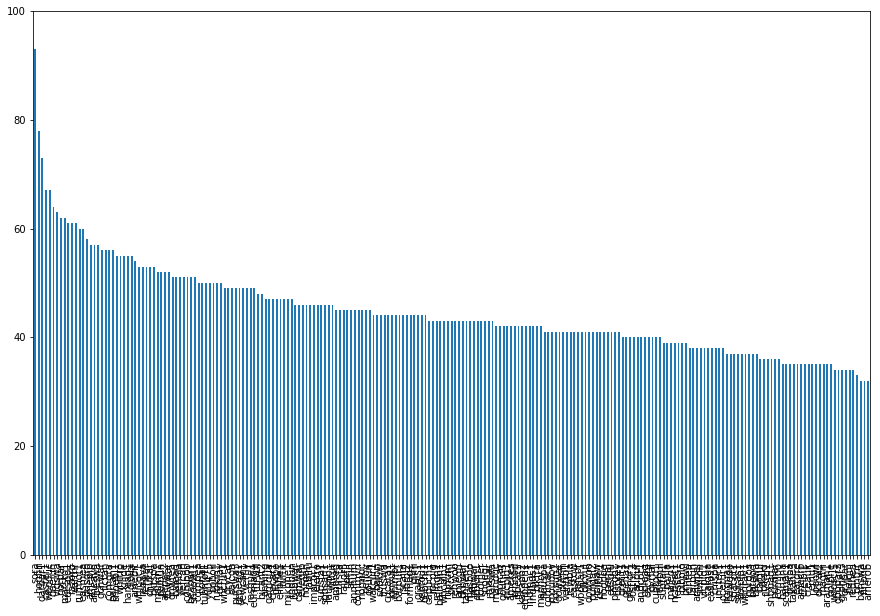

In [11]:
train.species.value_counts().sort_values(ascending=False).plot.bar(
    figsize=(15, 10), ylim=(0, 100)
);

## モデル構築
- EffientNetV2Lを使う
- ジェネレータを使ってAugumentation

###  検証データの作成

`ImageDataGenerator`の`flow_from_dataframe`を用いてバッチの作成時にデータを読み込む

In [12]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(train, test_size=0.2, stratify=train["species"])

train_df.reset_index(drop=True, inplace=True)
valid_df.reset_index(drop=True, inplace=True)

### ジェネレータの作成
- train用
    - 水平・垂直シフト
    - 水平フリップ
    - 拡大・縮小
    - channel_shift
    - 回転
    - コントラスト調整
    - シャープ化
    - mixup
- valid用
    - 何もしない
- test time augumentation用
    - train用のaugumentationを少し弱めにしたもの
    - mixupしない

In [13]:
# Validation用のジェネレータ
def validation_generator():
    gen = ImageDataGenerator(
        # rescale=1.0/255, 
    )
    return gen

# baseline用のジェネレータ
def base_datagen():
    gen = ImageDataGenerator(
        # rescale=1.0/255, 
        width_shift_range=22/224, 
        height_shift_range=22/224,
        horizontal_flip=True,
        zoom_range=[0.80, 1.10], 
        channel_shift_range=50.0, 
        rotation_range=5,
    )
    return gen

# ---

# test用のbaseジェネレータ
def test_base_datagen():
    gen = ImageDataGenerator(
        # rescale=1.0/255, 
        width_shift_range=11/224, 
        height_shift_range=11/224,
        horizontal_flip=True,
        zoom_range=[0.90, 1.10], 
        channel_shift_range=25.0, 
        rotation_range=5,
    )
    return gen

# ---

# オートコントラストの追加
def datagen_2(train_df, train_img_directory, target_size=(224, 224), batch_size=256, x_col="filename", y_col="species", seed=42, shuffle=True):
    base_train_flow = base_datagen().flow_from_dataframe(
        dataframe=train_df,
        directory=train_img_path,
        x_col=x_col,
        y_col=y_col,
        target_size=target_size,
        batch_size=batch_size,
        seed=42,
        shuffle=shuffle
    )
    
    # auto contrast 
    def auto_contrast(image, cutoff=0):
        if np.random.rand() >= 0.5:
            # array = (image * 255).astype(np.uint8)
            array = image.copy().astype(np.uint8)
            
            with Image.fromarray(array) as img:
                autocon = ImageOps.autocontrast(img, cutoff)
                # return np.asarray(autocon, np.float32) / 255.0
                return np.asarray(autocon, np.float32)
        else:
            return image
    
    # 50%の確率でauto contrastをかける
    for X_base, y_base in base_train_flow:
        X = np.array([auto_contrast(d, 0) for d in X_base])
        yield X, y_base

# ---
        
# シャープ化の追加        
def datagen_3(train_df, train_img_directory, target_size=(224, 224), batch_size=256, x_col="filename", y_col="species", seed=42, shuffle=True):
    datagen_2_flow = datagen_2(train_df, train_img_directory, target_size, batch_size, x_col, y_col, seed, shuffle)
    
    # sharp化
    def sharpen(image, magnitude):
        if np.random.rand() >= 0.0:
            # array = (image * 255).astype(np.uint8)
            array = image.astype(np.uint8)

            with Image.fromarray(array) as img:
                factor = np.random.uniform(1.0-magnitude, 1.0+magnitude)
                sharp = ImageEnhance.Sharpness(img).enhance(factor)
                # return np.asarray(sharp, np.float32) / 255.0        
                return np.asarray(sharp, np.float32)
        else:
            return image
    
    # シャープ化する
    for X_base, y_base in datagen_2_flow:
        X = np.array([sharpen(d, 1) for d in X_base])
        yield X, y_base

# ---
        
# mixupの追加
def datagen_4(train_df, train_img_directory, target_size=(224, 224), batch_size=256, x_col="filename", y_col="species", seed=42, shuffle=True):
    datagen_3_flow = datagen_3(train_df, train_img_directory, target_size, batch_size, x_col, y_col, seed, shuffle)
    
    # Mixup
    def mixup(X, y, beta=0.5):
        if np.random.rand() >= 0.1:
            shuffle_ind = np.random.permutation(X.shape[0])
            rand = np.random.beta(beta, beta)
            X_mix = rand * X + (1-rand) * X[shuffle_ind]
            y_mix = rand * y + (1-rand) * y[shuffle_ind]
            return X_mix, y_mix
        else:
            return X, y
        
    # mixup
    for X_base, y_base in datagen_3_flow:
        yield mixup(X_base, y_base, 0.5)
        

def test_gen(X_test, dummy_y, batch_size):
    base_gen_flow = test_base_datagen().flow(X_test, dummy_y, batch_size=batch_size, shuffle=False)
    
    # auto contrast 
    def auto_contrast(image, cutoff=0):
        if np.random.rand() >= 0.5:
            # array = (image * 255).astype(np.uint8)
            array = image.copy().astype(np.uint8)
            
            with Image.fromarray(array) as img:
                autocon = ImageOps.autocontrast(img, cutoff)
                # return np.asarray(autocon, np.float32) / 255.0
                return np.asarray(autocon, np.float32)
        else:
            return image
        
     # sharp化
    def sharpen(image, magnitude):
        if np.random.rand() >= 0.1:
            # array = (image * 255).astype(np.uint8)
            array = image.astype(np.uint8)

            with Image.fromarray(array) as img:
                factor = np.random.uniform(1.0-magnitude, 1.0+magnitude)
                sharp = ImageEnhance.Sharpness(img).enhance(factor)
                # return np.asarray(sharp, np.float32) / 255.0        
                return np.asarray(sharp, np.float32)
        else:
            return image
    
    # auto contrastとsharp化
    for X_base, y_base in base_gen_flow:
        # auto contrast
        X = np.array([auto_contrast(d, 0) for d in X_base])
        # sharp化
        X = np.array([sharpen(d, 1) for d in X_base])
        yield X, y_base

valid_flow

In [14]:
valid_gen = validation_generator()

VALID_BATCH_SIZE = 1
valid_flow = valid_gen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_img_path,
    x_col="filename",
    y_col="species",
    target_size=(224, 224),
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    seed=42
)

index2class = {v: k for k, v in valid_flow.class_indices.items()}

Found 2014 validated image filenames belonging to 225 classes.


train_flow

In [15]:
BATCH_SIZE = 256

train_flow = datagen_4(
    train_df=train_df,
    train_img_directory=train_img_path,
    x_col="filename",
    y_col="species",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=42, 
)

all_data_flow

In [16]:
BATCH_SIZE = 256

all_data_flow = datagen_4(
    train_df=train,
    train_img_directory=train_img_path,
    x_col="filename",
    y_col="species",
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    seed=42, 
)

Data Augmentationがかけられた様子を見てみる

Found 8055 validated image filenames belonging to 225 classes.


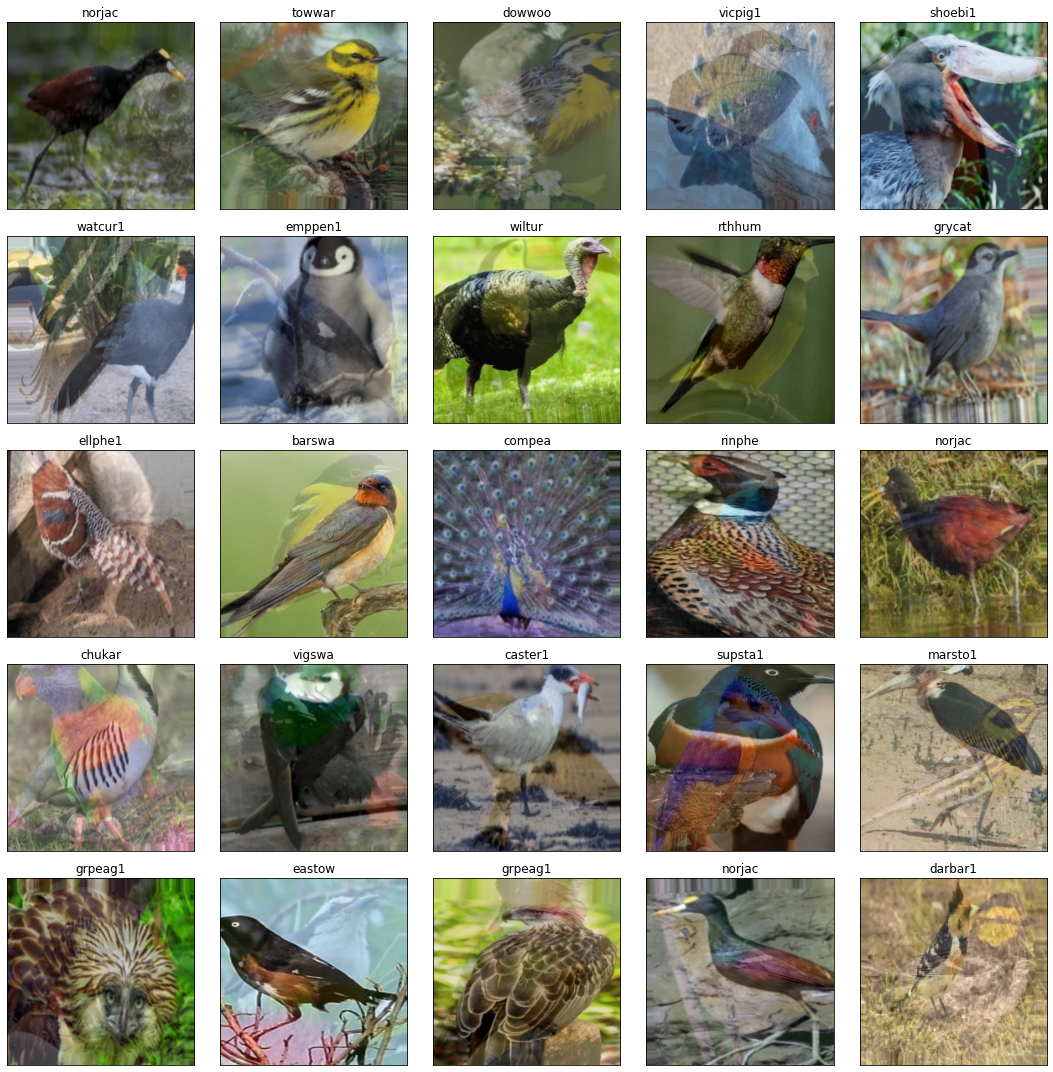

In [18]:
x, y = next(train_flow)
x_25, y_25 = x[:25], y[:25]
x_25 = x_25

nrows = 5
ncols = 5

index2class = {v: k for k, v in valid_flow.class_indices.items()}
gen = base_datagen()

fig, axes = plt.subplots(figsize=(3 * ncols, 3 * nrows), nrows=nrows, ncols=ncols)

for i in range(nrows):
    for j in range(ncols):
        img = x_25[i * nrows + j].astype(np.uint8)
        label = y_25[i * nrows + j]
        label_index = np.argmax(label)

        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{index2class[label_index]}")
        axes[i, j].tick_params(labelbottom=False, bottom=False)
        axes[i, j].tick_params(labelleft=False, left=False)

plt.tight_layout()
plt.show()

### モデルの定義

- EfficientNetV2Lを使用する
- finetuningとして`block7a_expand_conv`以降のレイヤを学習する

In [19]:
def get_model():
    base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2L(
        input_shape=(224, 224, 3), include_top=False, weights="imagenet"
    )

    # 学習させる部分の指定
    def finetuning(base_model, trainable_layer):
        '''
        trainable_layer以降のレイヤを学習可能にする
        '''
        layer_names = [l.name for l in base_model.layers]
        idx = layer_names.index(trainable_layer)
        print(len(layer_names), "：", idx)

        base_model.trainable = True
        for layer in base_model.layers[:idx]:
            layer.trainable = False

        return base_model

    base_model = finetuning(base_model, trainable_layer="block7a_expand_conv")

    model = tf.keras.Sequential(
        [
            base_model,
            layers.GlobalAveragePooling2D(), 
            layers.Dense(512, activation='relu'), 
            layers.Dropout(0.25),
            layers.Dense(
                train_df.species.nunique(),
                activation="softmax",
                kernel_initializer="glorot_normal",
            ),
        ]
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(lr=5e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    model.summary()
    return model

In [17]:
model = get_model()

2022-08-30 22:35:45.845648: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:35:46.691768: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:35:46.692777: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:35:46.695364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

473176280/473176280 [==============================] - 3s 0us/step
1028 ： 922
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 225)               115425    
                                            

/opt/venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### 学習の実行

In [22]:
def model_fit(model, epochs=100):
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    rlr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=0,
        min_delta=1e-4,
        mode='auto'
    )

    es = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta=1e-4,
        patience=8,
        mode='auto',
        baseline=None,
        restore_best_weights=True,
        verbose=0
    )
    
    # モデルの学習のたびに重みが上書きされてしまうので，file_pathをその都度変えましょう
    ckp = tf.keras.callbacks.ModelCheckpoint(
        filepath="best_val_model.h5", monitor="loss", verbose=1, save_best_only=True
    )

    history = model.fit(
        train_flow,
        steps_per_epoch=train_df.shape[0] // BATCH_SIZE,
        epochs=epochs,
        validation_data=valid_flow,
        validation_steps=valid_df.shape[0] // VALID_BATCH_SIZE,
        callbacks=[rlr, es, ckp],
    )
    
    return history, model

In [ ]:
history, model = model_fit(model)

2022-08-30 20:11:19.597424: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:11:19.598199: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:11:19.598920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:11:19.599782: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 20:11:19.600575: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

Epoch 1/100


2022-08-30 20:11:58.359576: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-08-30 20:12:14.329545: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 20:12:18.288727: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 20:12:18.504648: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

31/31 [==============================] - ETA: 0s - loss: 1.2098 - accuracy: 0.8919
Epoch 1: loss improved from inf to 1.20976, saving model to best_val_model.h5
14/31 [============>.................] - ETA: 2:15 - loss: 1.0222 - accuracy: 0.8901
Epoch 9: loss improved from 0.89749 to 0.85014, saving model to best_val_model.h5
31/31 [==============================] - 452s 15s/step - loss: 0.8501 - accuracy: 0.9115 - val_loss: 0.2417 - val_accuracy: 0.9523 - lr: 2.5000e-04
Epoch 10/100
31/31 [==============================] - ETA: 0s - loss: 1.1249 - accuracy: 0.8743
Epoch 10: loss did not improve from 0.85014
31/31 [==============================] - 443s 15s/step - loss: 1.1249 - accuracy: 0.8743 - val_loss: 0.2618 - val_accuracy: 0.9533 - lr: 2.5000e-04
Epoch 11/100
31/31 [==============================] - ETA: 0s - loss: 1.0698 - accuracy: 0.8933
Epoch 11: loss did not improve from 0.85014
31/31 [==============================] - 443s 14s/step - loss: 1.0698 - accuracy: 0.8933 - val_l

## 結果の描画

In [ ]:
def plot_history(history, key="loss"):
    plt.figure(figsize=(16, 8))

    ax = plt.plot(history.epoch, history.history[key], label=f"Train {key}")
    plt.plot(
        history.epoch,
        history.history[f"val_{key}"],
        "--",
        color=ax[0].get_color(),
        label=f"Val {key}",
    )

    plt.xlabel("Epochs")
    plt.ylabel(key.title())
    plt.legend()
    plt.xlim([0, max(history.epoch)])
    return

In [ ]:
plot_history(history, key="loss")

In [ ]:
plot_history(history, key="accuracy")

In [ ]:
def get_valid_result():
    valid_data_num = (valid_df.shape[0]//VALID_BATCH_SIZE) * VALID_BATCH_SIZE
    
    # X: 画像データ, y: 正解ラベル, pred: 予測値ラベル, pred_raw: モデルの予測値(確率値), correct: 正しい予測を行えたか
    valid_predict_result = {
        "X":[None]*valid_data_num, "y":[None]*valid_data_num, "pred":[None]*valid_data_num, "pred_raw":[None]*valid_data_num, 
        "correct":[None]*valid_data_num
    }

    for i in range(valid_df.shape[0]//VALID_BATCH_SIZE):
        gc.collect()
        valid_X, valid_y = next(valid_flow)
        pred_raw = model.predict(valid_X, verbose=0)
        pred = pred_raw.argmax(axis=1)

        for j, (X, y, p, p_w) in enumerate(zip(valid_X, valid_y, pred, pred_raw)):
            valid_predict_result["X"][i*VALID_BATCH_SIZE+j] = X
            valid_predict_result["y"][i*VALID_BATCH_SIZE+j] = y.argmax()
            valid_predict_result["pred"][i*VALID_BATCH_SIZE+j] = p
            valid_predict_result["pred_raw"][i*VALID_BATCH_SIZE+j] = p_w
            valid_predict_reslult["correct"][i*VALID_BATCH_SIZE+j] = y.argmax()==p
    
    # 混同行列
    print(confusion_matrix(valid_predict_result["y"], valid_predict_result["pred"]))
    
    # valid accuracy
    print(valid_predict_reslult[correct].sum() / len(valid_predict_reslult[correct]))
    
    return valid_predict_result

In [ ]:
valid_predict = get_valid_result()

In [29]:
# data = confusion_matrix(valid_predict["y"], valid_predict["pred"])
# np.savetxt('confusion_matrix.txt', data, fmt='%d')

## テストデータにおいて予測

学習データを全量使って学習した後、テストデータに対して学習したモデルで予測を行う

In [20]:
def model_fit_all_data(model, epochs=40):
    from tensorflow.compat.v1 import ConfigProto, InteractiveSession

    config = ConfigProto()
    config.gpu_options.allow_growth = True
    session = InteractiveSession(config=config)
    
    # 学習率 → 上記の結果を元に変える
    def step_decay(epoch):
        x = 0.0005
        if epoch >= 5: x = 0.00025
        if epoch >= 10: x = 0.000125
        if epoch >= 15: x = 0.0000625
        if epoch >= 20: x = 0.0000315
        if epoch >= 25: x = 0.000015
        if epoch >= 30: x = 0.0000075
        if epoch >= 35: x = 0.00000375
        return x
    
    lr_decay = tf.keras.callbacks.LearningRateScheduler(step_decay)

    history = model.fit(
        all_data_flow,
        steps_per_epoch=train_df.shape[0] // BATCH_SIZE,
        epochs=epochs,
        # validation_data=valid_flow,
        # validation_steps=valid_df.shape[0] // VALID_BATCH_SIZE,
        callbacks=[lr_decay],
    )
    return history, model

In [21]:
model = get_model()
history, model = model_fit_all_data(model)

model.save_weights('all_data_flow_param_L.h5')

2022-08-30 22:38:59.435188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:00.139606: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:00.140634: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:00.142470: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1028 ： 922
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 7, 7, 1280)       117746848 
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 225)               115425    
                                                                 
Total params: 118,518,145
Trainable params: 4

/opt/venv/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
2022-08-30 22:39:26.017031: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:26.017743: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:26.018375: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-30 22:39:26.019168: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative v

Found 10069 validated image filenames belonging to 225 classes.
Epoch 1/40


2022-08-30 22:40:08.187492: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200
2022-08-30 22:40:22.505939: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.13GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 22:40:22.700024: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.48GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2022-08-30 22:40:22.832736: W tensorflow/core/common_runtime/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.83GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains

31/31 [==============================] - 288s 8s/step - loss: 4.0226 - accuracy: 0.3299 - lr: 5.0000e-04
Epoch 2/40
31/31 [==============================] - 242s 8s/step - loss: 1.7476 - accuracy: 0.7594 - lr: 5.0000e-04
Epoch 3/40
31/31 [==============================] - 239s 8s/step - loss: 1.9022 - accuracy: 0.7623 - lr: 5.0000e-04
Epoch 4/40
31/31 [==============================] - 239s 8s/step - loss: 1.4970 - accuracy: 0.8366 - lr: 5.0000e-04
Epoch 5/40
31/31 [==============================] - 243s 8s/step - loss: 1.3055 - accuracy: 0.8628 - lr: 5.0000e-04
Epoch 6/40
31/31 [==============================] - 239s 8s/step - loss: 1.1836 - accuracy: 0.8773 - lr: 5.0000e-04
Epoch 7/40
31/31 [==============================] - 240s 8s/step - loss: 1.3048 - accuracy: 0.8531 - lr: 5.0000e-04
Epoch 8/40
31/31 [==============================] - 240s 8s/step - loss: 1.2228 - accuracy: 0.8780 - lr: 5.0000e-04
Epoch 9/40
31/31 [==============================] - 243s 8s/step - loss: 1.1123 - a

### TTAをして予測値を求める
- 同一画像に対してaugumentaionをして、20回予測を行った上で予測を確定する
- オリジナルのデータのに対する予測の重みは上げておく

In [25]:
from tqdm.notebook import tqdm

model.load_weights("all_data_flow_param_L.h5")
# model.load_weights("best_val_model.h5")

batch_size = 256
predictions = []
n_tta = 20

n_iter = (
    (len(test) // batch_size) + 1
    if len(test) % batch_size != 0
    else len(test) // batch_size
)

for i in tqdm(range(n_iter)):
    # 0~255, 256~511, ...の画像データ読み込み
    filenames = test.iloc[i * batch_size : (i + 1) * batch_size, 0].values.reshape(-1)
    images = []
    
    # 画像データの読み込み(cv2だとBGRなので、RGBに変換が必要)
    for filename in filenames:
        img = cv2.imread(str(test_img_path / filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        images.append(img)
    
    # TTA用のデータ
    X_test = np.array(images)
    del images, img
    
    y_dummy = np.array(["1"]*len(X_test))
    test_gen_temp = test_gen(X_test, y_dummy, len(X_test))
    
    # 拡張していないデータの重みを上げておく
    predict_temp = model.predict(X_test, verbose=0)*(n_tta//2)
    del X_test
    
    # Test Time Augmentation (複数回augumetationしたテスト画像の予測値を足し合わせて、最も確率の高いもの予測とする)
    for j in tqdm(range(n_tta)):
        X_test_aug, _ = next(test_gen_temp)
        predict_temp += model.predict(X_test_aug, verbose=0)
        del X_test_aug
        gc.collect()
    
    del test_gen_temp
    
    predictions.append(predict_temp.argmax(axis=1))
    
predictions = np.concatenate(predictions)
predicted_labels = [index2class[i] for i in predictions]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [26]:
# 提出する DataFrame を準備します
submission = pd.DataFrame({"label": predicted_labels})
submission

,label
0,golpip1
1,golpip1
2,banana
3,golpip1
4,sobkiw
...,...
11743,darbar1
11744,supsta1
11745,gilfli
11746,capuch1


---

### MixUp

[MixUp](https://arxiv.org/abs/1710.09412)はData Augmentationの一つで，二つの画像を重ね合わせる手法 <br>
具体的には，二つのでデータセットを$(X_1,y_1)$，$(X_2,y_2)$を
$$
X = \lambda X_1  + (1-\lambda) X_2 
$$
$$
y = \lambda y_1 + (1-\lambda) y_2
$$
の式にしたがって混ぜ合わせる (ただし，ここで$\lambda$は$\beta$分布に従う乱数値)<br>
<br>

<img src="https://hoya012.github.io/assets/img/bag_of_trick/9.PNG" width=30%>

### Test Time Augmentation (TTA)

- Data Augmentationは通常は訓練時にのみ使用される手法ですが，推論時にも使用することで，推論効率を上げることができる
- 具体的には，テストデータに対してもData Augmentationを行い，1枚の訓練画像から複数枚の画像を生成する
- それぞれの画像に対して推論を行い，その平均値を最終的な予測結果とする
- 推論時間が長くなってしまうという問題点はあるものの，有効な手法として知られている